In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import *

# geometric distribution for trials prob(n) = p q^(n-1) where p is success probability
F_geo = lambda x,p: np.floor(np.log(1-x)/np.log(1-p))
f = lambda x,p: p* (1-p)**(x-1)
# photon transmission probability in fiber (i.e., 0.2dB/km)
Trans = lambda x: 10**(-0.2*x/10)
# Binary Shanon entropy
def h(p_list):
    y_list = np.zeros(len(p_list))
    for i,p in enumerate(p_list):
        if p<1e-6 or (1-p)<1e-6:
            y_list[i]= 0
        else:
            y_list[i]= -p*np.log2(p)-(1-p)*np.log2(1-p)
    return y_list

## no cutoff

In [25]:
# constants
c = 2e5 # speed of light in fiber [km/s]
p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware

def T_parallel_no_cutoff(τ_coh, mu_link, F_link, links, cct= True, Nmax=10000):
    """ Runs Monte-Carlo iterations to calculate performance metrics for asynchronous parallel scheme
    inputs:
        τ_coh: coherence time of quantum memories
        mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
        entanglement swapping error
        F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        links: list of segment (link) lengths in km
        cct: bool flag to turn on/off classical comm.
        Nmax: No. of MC iterations (if you see oscillations in secret key curves, you need to try larger numbers)

    outputs:
        Raw_rate: 1/ expected value of total time for e2e entanglement delivery
        *** application specific quantities:
        skr: secret key rate for qkd (does not include idle times of end memories)
        F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
    """
    Nmax = int(Nmax) # to make sure Nmax is an integer
    N_links = len(links) # number of links, i.e. no. of repeaters + 1
    if type(links) != np.ndarray:
        links = np.array(links)
    τs = links/c
    Ns = np.zeros((N_links,Nmax))
    Ns[0,:] = (2*F_geo(np.random.rand(Nmax),p_link*Trans(links[0]))-1)*τs[0]
    for i in range(1,N_links):
        Ns[i,:] = 2*F_geo(np.random.rand(Nmax),p_link*Trans(links[i]))*τs[i]
    
    Ts = np.zeros((N_links-1,Nmax))
    Ts[0,:] = np.abs(Ns[1,:]-Ns[0,:])+ 2*τs[1]
    for i in range(1,N_links-1):
        Ts[i,:] = np.abs(Ns[i+1,:]-Ns[i,:]+τs[i])+ 2*τs[i+1]
    f_memory_qkd = np.mean(np.exp(-np.sum(Ts,axis=0)/τ_coh))
    if cct: # inclduing classical comm. 
        Tsw = np.zeros((N_links-1,Nmax))
        Tsw[0,:] = np.max([Ns[1,:],Ns[0,:]],axis=0) + np.sum(τs[:1])
        for i in range(1,N_links-1):
            Tsw[i,:] = np.max([Ns[i+1,:],Ns[i,:]-τs[i]],axis=0)+ np.sum(τs[:(i+1)])
            
        T_tot = np.mean(np.max(Tsw,axis=0))           
        Ts_A = np.max(Tsw,axis=0)-Ns[0,:] + τs[0] 
        Ts_B = np.max(Tsw,axis=0)-Ns[-1,:] + τs[-1] 
        f_memory_bell = np.mean(np.exp(-(np.sum(Ts,axis=0)+Ts_A+Ts_B)/τ_coh))
    else:
        T_tot = np.mean(np.max(Ns,axis=0))
        Ts_A = np.max(Ns,axis=0)-Ns[0,:] + τs[0] 
        Ts_B = np.max(Ns,axis=0)-Ns[-1,:] + τs[-1] 
        f_memory_bell = np.mean(np.exp(-(np.sum(Ts,axis=0)+Ts_A+Ts_B)/τ_coh))

    raw_rate = 1/T_tot
    mu_e2e = mu_link**(2*N_links-1)
    # secret key rate calculations
    f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
    ex = (1 - mu_e2e)/2
    ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
    skr = raw_rate * (1-h([ex])-h([ez]))
    #  fidelity of e2e Bell pairs
    f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
    F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
    return raw_rate, skr, F_e2e


def T_sequential_no_cutoff(τ_coh, mu_link, F_link,links):
    """ Calculate performance metrics for asynchronous sequential scheme using analytical formulas
    inputs:
        τ_coh: coherence time of quantum memories
        mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
        entanglement swapping error
        F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        links: list of segment (link) lengths in km
    outputs:
        Raw_rate: 1/ expected value of total time for e2e entanglement delivery
        *** application specific quantities:
        skr: secret key rate for qkd (does not include idle times of end memories)
        F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
    """
    if type(links) != np.ndarray:
        links = np.array(links)
    τs = links/c
    T_tot = 2* np.sum( τs / (p_link*Trans(links)) )

    raw_rate = 1/T_tot
    N_links = len(links) # number of links, i.e. no. of repeaters + 1
    mu_e2e = mu_link**(2*N_links-1)
    # secret key rate calculations
    f_memory_qkd = np.prod( p_link*Trans(links[1:])*np.exp(-4*τs[1:]/τ_coh)/(1- (1-p_link*Trans(links[1:]))*np.exp(-2*τs[1:]/τ_coh) )  )
    f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
    ex = (1 - mu_e2e)/2
    ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
    skr = raw_rate * (1-h([ex])-h([ez]))
    #  fidelity of e2e Bell pairs
    Le2e = np.sum(links)
    τe2e = Le2e/c
    f_memory_bell = np.exp(-3*τe2e/τ_coh) *np.prod(p_link*Trans(links[1:])*np.exp(-4*τs[1:]/τ_coh)/(1- (1-p_link*Trans(links[1:]))*np.exp(-4*τs[1:]/τ_coh) ) )
    f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
    F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4

    return raw_rate, skr, F_e2e


## rate vs. distance
uniform repeater chain

In [28]:
τ_coh = 0.1
n = 8 # number of segments (i.e., no. of repeaters -1 )
F_link = 1 # fidelity of local BP
mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)

Le2e_list = np.linspace(10,800,101) # e2e distance [km]
raw_rate_par = np.zeros(len(Le2e_list))
raw_rate_seq = np.zeros(len(Le2e_list))
skr_par = np.zeros(len(Le2e_list))
skr_seq = np.zeros(len(Le2e_list))
Fe2e_par = np.zeros(len(Le2e_list))
Fe2e_seq = np.zeros(len(Le2e_list))

for i, Le2e in enumerate(Le2e_list):
    Ls = np.array([Le2e/n]*n)
    raw_rate_par[i], skr_par[i], Fe2e_par[i] = T_parallel_no_cutoff(τ_coh, mu_link, F_link, Ls, cct= True, Nmax=1e6)
    raw_rate_seq[i], skr_seq[i], Fe2e_seq[i] = T_sequential_no_cutoff(τ_coh, mu_link, F_link, Ls)


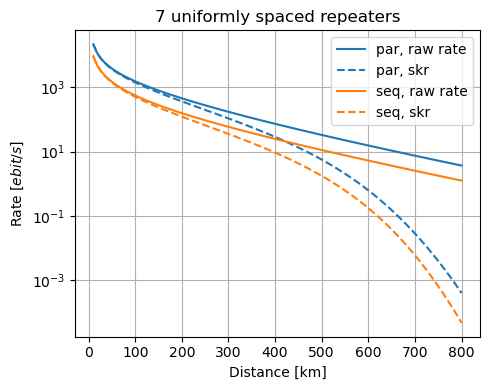

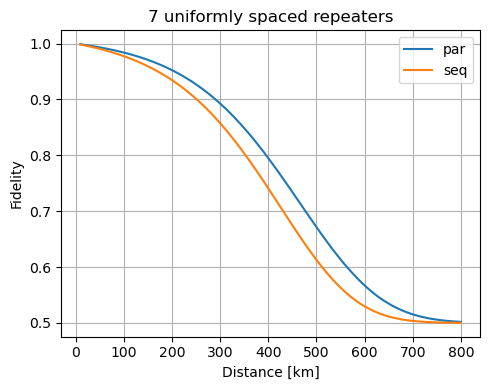

In [32]:
plt.figure(figsize=(5,4))
# plt.plot(Le2e_list,-np.log2(1-Trans(Le2e_list)),"k--", label="PLOB")
plt.plot(Le2e_list,raw_rate_par,"-",color="C0", label="par, raw rate")
plt.plot(Le2e_list,skr_par,"--",color="C0", label="par, skr")
plt.plot(Le2e_list,raw_rate_seq,"-",color="C1", label="seq, raw rate")
plt.plot(Le2e_list,skr_seq,"--",color="C1", label="seq, skr")
plt.yscale("log")
plt.xlabel("Distance [km]")
plt.ylabel(r"Rate $[ebit/s]$")
# plt.ylim([1e-4,1e5])
plt.title(f"{n-1} uniformly spaced repeaters")
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("figures_realtime/one_repeater_no_cutoff.pdf")
plt.show()


plt.figure(figsize=(5,4))
plt.plot(Le2e_list,Fe2e_par,"-", label="par")
plt.plot(Le2e_list,Fe2e_seq,"-", label="seq")
plt.title(f"{n-1} uniformly spaced repeaters")
# plt.yscale("log")
plt.xlabel("Distance [km]")
# plt.ylabel(r"$T_{mem}/τ_{coh}$")
plt.ylabel("Fidelity")
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("figures_realtime/one_repeater_fidelity_no_cutoff.pdf")
plt.show()
